# 2 Player FPSB Auction with uniform symmetric valuation distributions

## Imports

In [1]:
import os
import sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
from timeit import default_timer as timer

In [2]:
import torch
import torch.nn as nn
import torch.nn.utils as ut
from torch.optim.optimizer import Optimizer, required

In [3]:
from bnelearn.strategy import NeuralNetStrategy, TruthfulStrategy
from bnelearn.bidder import Bidder
from bnelearn.mechanism import FirstPriceSealedBidAuction, VickreyAuction
from bnelearn.optimizer import ES
from bnelearn.environment import AuctionEnvironment

In [4]:
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
#
#plt.ion()

In [5]:
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'

# Use specific cuda gpu if desired (i.e. for running multiple experiments in parallel)
specific_gpu = None
if cuda and specific_gpu:
    torch.cuda.set_device(specific_gpu)

print(device)

cuda


## Settings

The following cell fully defines an experiment.
The following set of parameters works well:
```
batch_size = 2**14
size_hidden_layer = 10

learning_rate = 1e-1
lr_decay = True
lr_decay_every = 500
lr_decay_factor = 0.8
baseline = True
momentum = 0.7

sigma = .02 #ES noise parameter
n_perturbations = 256
```

In [7]:
run_dir = 'fpsb_2p_sym_uniform'
run_name = 'run_5'
logdir = os.path.join(root_path, 'notebooks', run_dir , run_name)

## Experiment setup
n_players = 2
n_items = 1
# valuation distribution
u_lo =0
u_hi =10

def strat_to_bidder(strategy, batch_size):
    return Bidder.uniform(u_lo, u_hi, strategy, batch_size = batch_size, n_players=1)

#def strat_to_bidder(strategy, batch_size):
#    return Bidder.normal(10.0, 5.0, strategy, batch_size = batch_size, n_players=1)

## Environment settings
#training batch size
batch_size = 2**14
input_length = 1

# strategy model architecture
size_hidden_layer = 10

# optimization params
epoch = 5000
learning_rate = 1e-1
lr_decay = True
lr_decay_every = 500
lr_decay_factor = 0.8
baseline = True
momentum = 0.7

sigma = .02 #ES noise parameter
n_perturbations = 256

# plot and log training options
plot_epoch = 500
plot_points = min(100, batch_size)

plot_xmin = u_lo
plot_xmax = u_hi
plot_ymin = 0
plot_ymax = 10

## Setting up the Environment

In [8]:
# for evaluation
def optimal_bid(valuation):
    return valuation * (n_players - 1) / n_players

def log_hyperparams(writer, e):
    writer.add_scalar('hyperparams/batch_size', batch_size, e)
    writer.add_scalar('hyperparams/size_hidden_layer', size_hidden_layer, 0)
    writer.add_scalar('hyperparams/learning_rate', learning_rate, e)
    writer.add_scalar('hyperparams/momentum', momentum, e)
    writer.add_scalar('hyperparams/sigma', sigma, e)
    writer.add_scalar('hyperparams/n_perturbations', n_perturbations, e)

v_opt = np.linspace(plot_xmin, plot_xmax, 100)
b_opt = optimal_bid(v_opt)
    
def plot_bid_function(fig, v,b, writer=None, e=None, plot_points=plot_points):
    
    # subsample points and plot
    v = v.detach().cpu().numpy()[:plot_points]
    b= b.detach().cpu().numpy()[:plot_points]
    
    fig = plt.gcf()
    plt.cla()
    plt.xlim(plot_xmin, plot_xmax)
    plt.ylim(plot_ymin, plot_ymax)
    plt.plot(v,b, 'o', v_opt, b_opt, 'r--')
    #if is_ipython:
        #display.clear_output(wait=True)
    display.display(plt.gcf())
    if writer:
        writer.add_figure('eval/bid_function', fig, e)  

Initialize the model.
We'll ensure the initialization provides positive outputs on the domain we are interested in, as otherwise we can't learn.

In [10]:
output_is_positive = False
while not output_is_positive:
    model = NeuralNetStrategy(input_length,
                              size_hidden_layer = size_hidden_layer,
                              requires_grad=False
                             ).to(device)
    
    if model(torch.tensor([float(u_hi)], device=device)) > 0:
        output_is_positive = True    

In [11]:
mechanism = FirstPriceSealedBidAuction(cuda = True)
env = AuctionEnvironment(mechanism,
                  agents = [], #dynamically built
                  max_env_size = 1, #
                  batch_size = batch_size,
                  n_players =n_players,
                  strategy_to_bidder_closure = strat_to_bidder
                 )
optimizer = ES(model=model, environment = env,
               lr = learning_rate, momentum=momentum,
               sigma=sigma, n_perturbations=n_perturbations,
               baseline=baseline)

## Training

Epoch 0: 	total share: 0.359, diff: -1.605, 	utility: 4.107


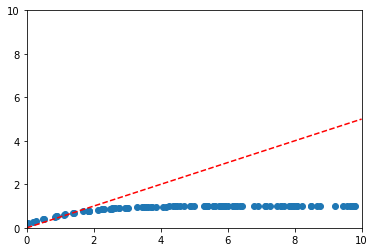

Logging checkpoint took 0.19s.
Epoch 500: 	total share: 1.378, diff: 0.950, 	utility: 1.536


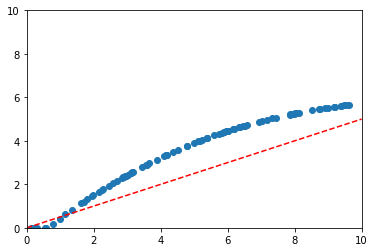

Logging checkpoint took 0.17s.
Epoch 1000: 	total share: 1.113, diff: 0.282, 	utility: 2.201


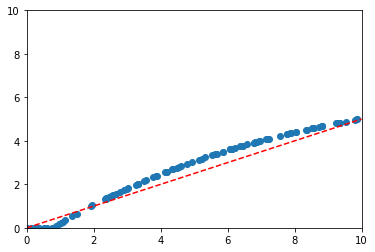

Logging checkpoint took 0.17s.
Epoch 1500: 	total share: 1.069, diff: 0.173, 	utility: 2.237


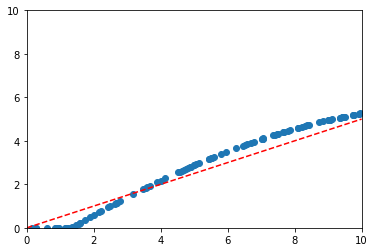

Logging checkpoint took 0.19s.
Epoch 2000: 	total share: 1.206, diff: 0.514, 	utility: 2.000


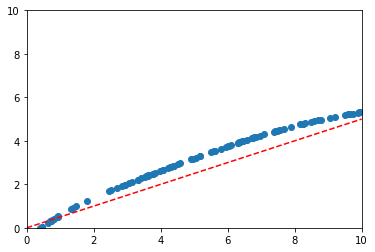

Logging checkpoint took 0.18s.
Epoch 2500: 	total share: 1.177, diff: 0.442, 	utility: 2.035


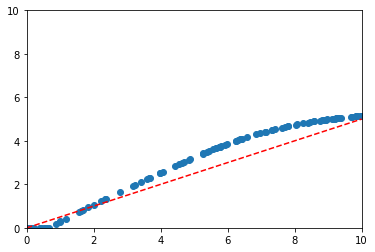

Logging checkpoint took 0.17s.
Epoch 3000: 	total share: 0.976, diff: -0.060, 	utility: 2.470


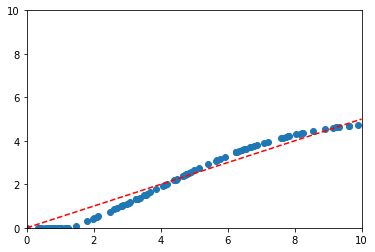

Logging checkpoint took 0.17s.
Epoch 3500: 	total share: 1.077, diff: 0.191, 	utility: 2.255


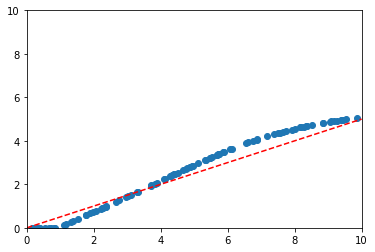

Logging checkpoint took 0.17s.
Epoch 4000: 	total share: 0.903, diff: -0.244, 	utility: 2.688


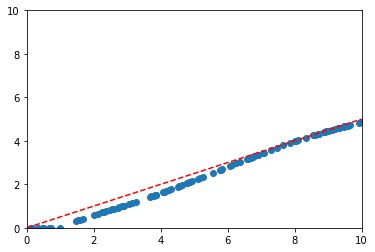

Logging checkpoint took 0.21s.
Epoch 4500: 	total share: 1.038, diff: 0.097, 	utility: 2.371


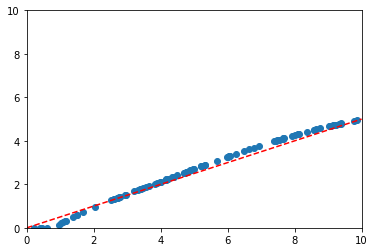

Logging checkpoint took 0.17s.
Epoch 5000: 	total share: 1.031, diff: 0.077, 	utility: 2.435


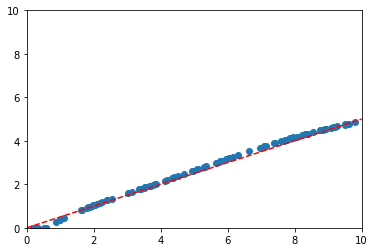

Logging checkpoint took 0.16s.


In [12]:
with SummaryWriter(logdir, flush_secs=30) as writer:
    torch.cuda.empty_cache()
    log_hyperparams(writer, 0)
    fig = plt.figure()
    for e in range(epoch+1):
        # lr decay?
        if lr_decay and e % lr_decay_every == 0 and e > 0:
            learning_rate = learning_rate * lr_decay_factor
            log_hyperparams(writer, e)
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate

        # always: do optimizer step
        utility = -optimizer.step()
        writer.add_scalar('eval/utility', utility, e)

        if e % plot_epoch == 0:
            start_time = timer()
            # plot current function output
            bidder = strat_to_bidder(model, batch_size)
            bidder.draw_valuations_()
            v = bidder.valuations
            b = bidder.get_action()
            share = b.mean()/optimal_bid(v).mean()
            diff = (b-optimal_bid(v)).mean()
            writer.add_scalar('eval/share', share, e)
            writer.add_scalar('eval/diff', diff, e)
            writer.add_graph(model, bidder.valuations) 

            print("Epoch {}: \ttotal share: {:.3f}, diff: {:.3f}, \tutility: {:.3f}".format(e, share, diff, utility))
            plot_bid_function(fig, v,b,writer,e)
            
            elapsed = timer() - start_time
            print("Logging checkpoint took {:.2f}s.".format(elapsed))         
            